In [13]:
import jesse.helpers as jh
from jesse.strategies import Strategy
from jesse import utils
from jesse.research import backtest, get_candles, candlestick_chart


In [37]:
candles_kava = get_candles(exchange="Binance", symbol="KAVA-USDT", timeframe="15m", start_date="2020-01-01", finish_date="2022-01-01")
import strategies.Kava_bb_rsi as kbb


In [26]:
import jesse.utils as jutils
df = jutils.numpy_candles_to_dataframe(candles_kava)


<AxesSubplot:>

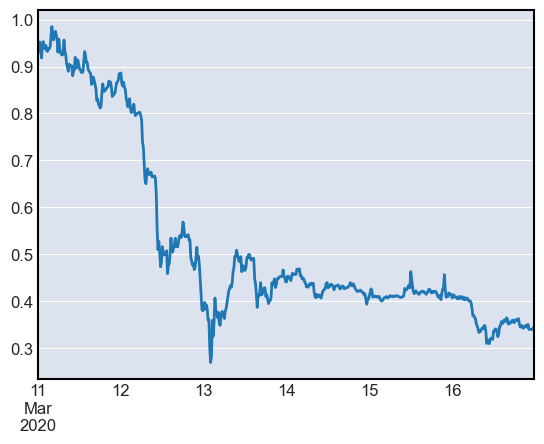

In [33]:
df["close"].loc["2020-03-11": "2020-03-16"].plot()


Config

In [38]:

exchange_name = 'Binance'
symbol = 'KAVA-USDT'
timeframe = '15m'
config = {
    'starting_balance': 10_000,
    'fee': 0.001,
    'futures_leverage': 2,
    'futures_leverage_mode': 'cross',
    'exchange': exchange_name,
    'settlement_currency': 'USDT',
    'warm_up_candles': 0
}
routes = [
    {'exchange': exchange_name, 'strategy': kbb.Kava_bb_rsi, 'symbol': symbol, 'timeframe': timeframe}
]
extra_routes = []
candles = {
    # keys must be in this format: 'Fake Exchange-BTC-USDT'
    jh.key(exchange_name, symbol): {
        'exchange': exchange_name,
        'symbol': symbol,
        'candles': candles_kava,
    },
}



### Backtest

[{'id': 'ad27bdd3-d7cb-424a-bcff-e5e217eef461',
  'timestamp': 1577836800000.0,
  'message': 'Saved daily portfolio balance: 10000.0'},
 {'id': '49714686-609c-477f-8a7f-d1036da99988',
  'timestamp': 1579132860000.0,
  'message': 'Saved daily portfolio balance: 10000.0'},
 {'id': '116f4935-fc94-41dd-9bb5-67fdf36d5772',
  'timestamp': 1580428860000.0,
  'message': 'Saved daily portfolio balance: 10000.0'},
 {'id': 'ffcbced6-c448-4ef3-8f1e-f29ebf828f27',
  'timestamp': 1581724860000.0,
  'message': 'Saved daily portfolio balance: 10000.0'},
 {'id': '4cb45708-f09f-470f-a141-92e8c038b2d3',
  'timestamp': 1581845460000.0,
  'message': 'Charged 9.97 as fee. Balance for USDT on Binance changed from 10000.0 to 9990.03'},
 {'id': '2a5060dc-8f15-4dcb-966a-3f023d9aac47',
  'timestamp': 1583020860000.0,
  'message': 'Saved daily portfolio balance: 7295.65'},
 {'id': 'e5b9aaa0-8417-49ac-ae8c-3028cd2d3f4f',
  'timestamp': 1583249460000.0,
  'message': 'Charged 7.79 as fee. Balance for USDT on Binance

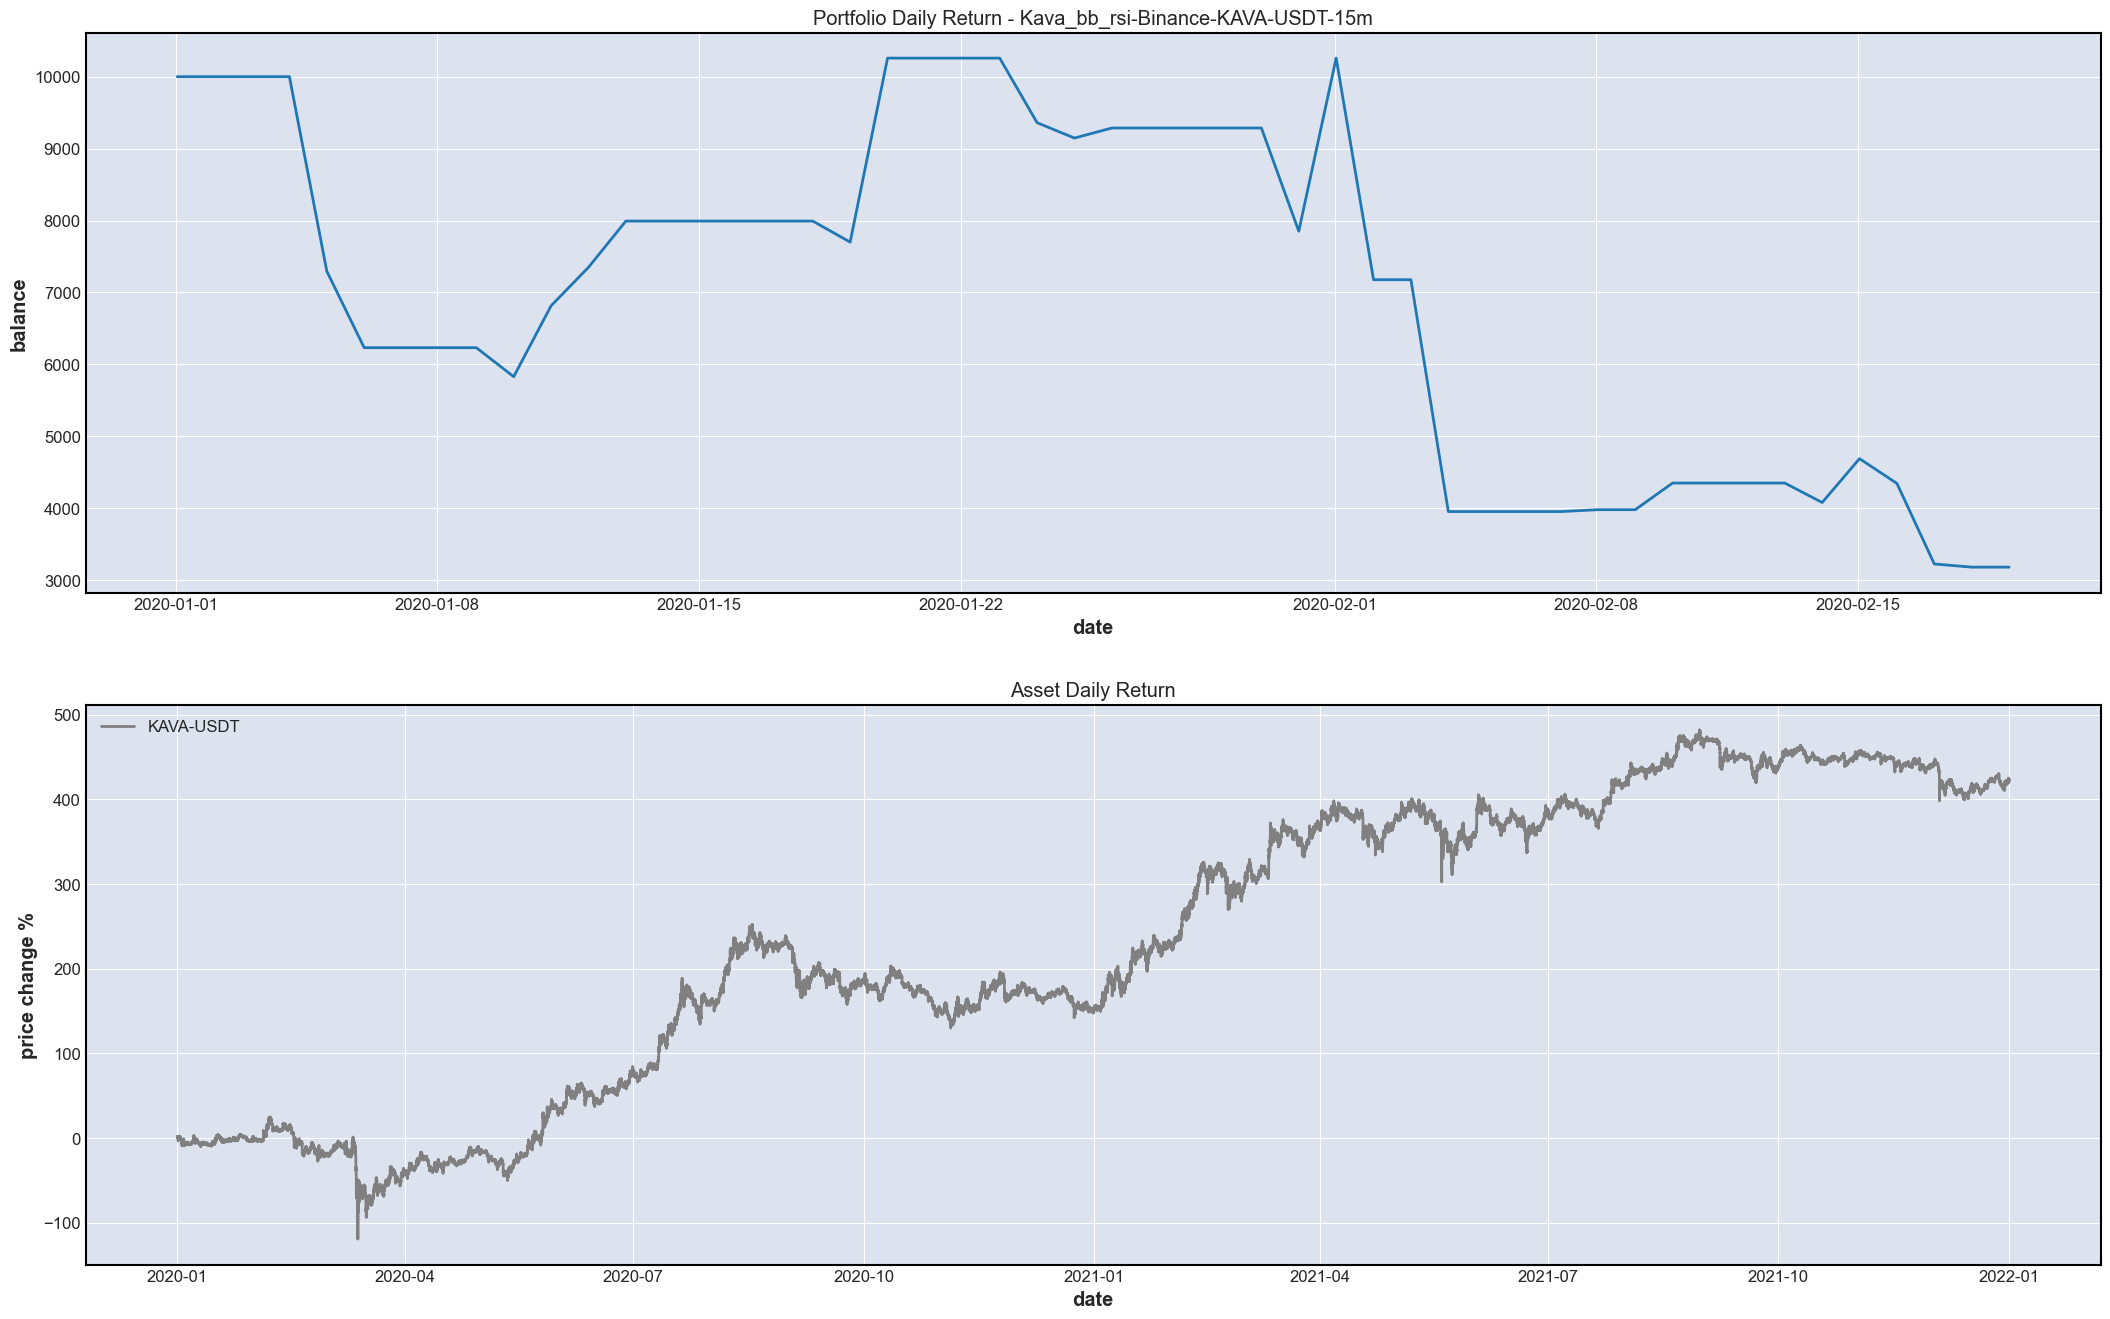

In [39]:
result = backtest(
    config,
    routes,
    extra_routes,
    candles, 
    generate_charts=True
)
# to access the metrics dict:
result['metrics']
# to access the charts string (path of the generated file): 
result['charts']
# to access the logs list:
result['logs']


In [57]:
#CCXT for OHLCV gets only 720 candles
import ccxt
from datetime import datetime
kraken = ccxt.kraken()
res = kraken.fetch_trades("KAVAUSD", since= datetime.timestamp(datetime(2022, 3, 1)), limit=500)


ExchangeError: kraken fetchTrades() cannot serve 500 trades without breaking the pagination, see https://github.com/ccxt/ccxt/issues/5698 for more details. Set exchange.options['fetchTradesWarning'] to acknowledge self warning and silence it.

In [107]:
import krakenex as k
from datetime import datetime

k_api = k.API()

payload = {"pair":"BTCUSD", 
           "since": "1650384928"}


response = k_api.query_public("Trades", payload)

print(response["result"]["last"])
#resp = requests.get('https://api.kraken.com/0/public/Trades?pair=XBTUSD&since=86400000')
#print(resp.json())

1650388458003832822


In [108]:
import requests
endpoint = "https://api.kraken.com/0/public/Trades"
response = requests.get(endpoint, params=payload)




TypeError: 'Response' object is not subscriptable

In [109]:
data = response.json()
index = list(data["result"].keys())[0]
res = data["result"][index]


In [110]:
last_index = list(data["result"].keys())[1]
data["result"]["last"]

'1650388458003832822'

In [111]:
from itertools import chain
li = []
li.append(res)
li.append(res)
res_list = list(chain(*li))

In [218]:
import pandas as pd
df = pd.DataFrame(res_list, columns=["price", "amount", "timestamp", "direction", "ordertype", "mist"])
df.index = df.timestamp
df.index = pd.to_datetime(df.index, unit='s')
df.amount = df.amount.astype(float)

ohlcv = pd.DataFrame()
ohlcv['open'] = df.resample('1min')['price'].agg('first')
ohlcv['high'] = df.resample('1min')['price'].agg('max')
ohlcv['low'] = df.resample('1min')['price'].agg('min')
ohlcv['close'] = df.resample('1min')['price'].agg('last')
ohlcv['volume'] = df.resample('1min')['amount'].agg('sum')

unix_epoch = np.datetime64(0, 's')
one_second = np.timedelta64(1, 's')
seconds_since_epoch = (ohlcv.index.to_numpy() - unix_epoch) / one_second
ohlcv["timestamp2"] = seconds_since_epoch

ohlcv2 = ohlcv.reset_index()
ohlcv2 = ohlcv2.drop(columns=['timestamp'])
ohlcv2 = ohlcv2.to_dict(orient = "records")
[{
#'id': jh.generate_unique_id(),
'symbol': "symbol",
'exchange': "self.name",
'timestamp': int(d["timestamp2"]),
'open': float(d["open"]),
'close': float(d["close"]),
'high': float(d["high"]),
'low': float(d["low"]),
'volume': float(d["volume"])
} for d in ohlcv2]




[{'open': '41488.70000',
  'high': '41488.70000',
  'low': '41478.10000',
  'close': '41478.10000',
  'volume': 0.00040862,
  'timestamp2': 1650384900.0},
 {'open': '41478.10000',
  'high': '41487.30000',
  'low': '41472.00000',
  'close': '41481.10000',
  'volume': 0.40996047999999996,
  'timestamp2': 1650384960.0},
 {'open': '41484.10000',
  'high': '41484.10000',
  'low': '41467.10000',
  'close': '41467.10000',
  'volume': 2.78918234,
  'timestamp2': 1650385020.0},
 {'open': '41467.10000',
  'high': '41485.70000',
  'low': '41467.10000',
  'close': '41485.70000',
  'volume': 1.5250656599999999,
  'timestamp2': 1650385080.0},
 {'open': '41490.80000',
  'high': '41508.60000',
  'low': '41490.80000',
  'close': '41508.60000',
  'volume': 2.1001792,
  'timestamp2': 1650385140.0},
 {'open': '41508.60000',
  'high': '41521.80000',
  'low': '41503.00000',
  'close': '41509.90000',
  'volume': 3.80726056,
  'timestamp2': 1650385200.0},
 {'open': '41509.90000',
  'high': '41522.80000',
  'l

In [224]:

[{
#'id': jh.generate_unique_id(),
'symbol': "symbol",
'exchange': "name",
'timestamp': int(d["timestamp2"]),
'open': float(d["open"]),
'close': float(d["close"]),
'high': float(d["high"]),
'low': float(d["low"]),
'volume': float(d["volume"])
} for d in test]


[{'symbol': 'symbol',
  'exchange': 'name',
  'timestamp': 1650384900,
  'open': 41488.7,
  'close': 41478.1,
  'high': 41488.7,
  'low': 41478.1,
  'volume': 0.00040862},
 {'symbol': 'symbol',
  'exchange': 'name',
  'timestamp': 1650384960,
  'open': 41478.1,
  'close': 41481.1,
  'high': 41487.3,
  'low': 41472.0,
  'volume': 0.40996047999999996},
 {'symbol': 'symbol',
  'exchange': 'name',
  'timestamp': 1650385020,
  'open': 41484.1,
  'close': 41467.1,
  'high': 41484.1,
  'low': 41467.1,
  'volume': 2.78918234},
 {'symbol': 'symbol',
  'exchange': 'name',
  'timestamp': 1650385080,
  'open': 41467.1,
  'close': 41485.7,
  'high': 41485.7,
  'low': 41467.1,
  'volume': 1.5250656599999999},
 {'symbol': 'symbol',
  'exchange': 'name',
  'timestamp': 1650385140,
  'open': 41490.8,
  'close': 41508.6,
  'high': 41508.6,
  'low': 41490.8,
  'volume': 2.1001792},
 {'symbol': 'symbol',
  'exchange': 'name',
  'timestamp': 1650385200,
  'open': 41508.6,
  'close': 41509.9,
  'high': 4152

In [317]:
from drivers.config import API_KEY, API_SECRET
import krakenex as k

payload = {"pair":"BTCUSD", 
           "since": "1650384928"}


API = k.API(key=API_KEY, secret=API_SECRET)
data = API.query_public(method="Trades", data=payload)


In [340]:
1/3

0.3333333333333333

In [65]:
from drivers import kraken
from importlib import reload
from jesse.modes import import_candles_mode
reload(kraken)
kraken_driver = kraken.Kraken()
res = kraken_driver.fetch(symbol="KAVAUSD", start_timestamp_ms=1650031130000)


fetching function started
entering loop 0
start_timestamp_ms: 1650031130000 end_timestamp_ms: 1650091080000
broke loop  False 1650135008280 1650091080000 1650135008280.0


210

In [ ]:
reload(import_candles_mode)
import_candles_mode.run("Kraken", "KAVA-USD", "2022-04-01", running_via_dashboard=False)


In [32]:
len(res)

1

In [ ]:

#test = kraken.Kraken()
#res = test.fetch("KAVAUSD", start_timestamp=1648821530)




In [3]:
res

[{'id': 'a97b751e-bc57-4429-90b3-d7c52188b57d',
  'symbol': 'KAVAUSD',
  'exchange': 'Kraken',
  'timestamp': 1648821720,
  'open': 4.421199798583984,
  'close': 4.414000034332275,
  'high': 4.421199798583984,
  'low': 1.1309146881103516,
  'volume': 251.15668296813965},
 {'id': '681b8971-8fae-4e8a-a4ab-491939d307df',
  'symbol': 'KAVAUSD',
  'exchange': 'Kraken',
  'timestamp': 1648821840,
  'open': 4.418099880218506,
  'close': 4.418099880218506,
  'high': 4.418099880218506,
  'low': 4.102799892425537,
  'volume': 4.102799892425537},
 {'id': 'd20dfe4b-dc14-4035-8961-f66ee339a9f3',
  'symbol': 'KAVAUSD',
  'exchange': 'Kraken',
  'timestamp': 1648821960,
  'open': 4.440700054168701,
  'close': 4.440700054168701,
  'high': 4.440700054168701,
  'low': 4.440700054168701,
  'volume': 10.0},
 {'id': '67353846-4e89-41a6-8472-9877a449e7e0',
  'symbol': 'KAVAUSD',
  'exchange': 'Kraken',
  'timestamp': 1648822260,
  'open': 4.441100120544434,
  'close': 4.441100120544434,
  'high': 4.44110012

In [ ]:
arry = res[:,0:3]
arry = arry.astype(np.float32)
lin_space = np.linspace(1650463130 , 1650523080.0, 1000)
index = np.searchsorted(arry[:,2], lin_space)
arry_list = np.split(arry, index)
arry_list = [x for x in arry_list if len(x) > 0]
ohlcv = [{"open": r[0,0], "high":np.max(r[:,0]), "low":np.min(r[0]), "close":r[0,-1], "volume":sum(r[:,1])} for r in arry_list]


In [162]:
res

array([['4.34180', '100.00000000', '1650463206.6187665', 'b', 'l', ''],
       ['4.34190', '12.76290200', '1650463206.6208942', 'b', 'l', ''],
       ['4.34210', '60.00000000', '1650463280.5447035', 's', 'm', ''],
       ...,
       ['4.50420', '53.32718701', '1650501996.5784805', 'b', 'l', ''],
       ['4.50420', '254.58843433', '1650501996.5833619', 'b', 'l', ''],
       ['4.50670', '7.76441150', '1650501996.6363916', 'b', 'l', '']],
      dtype='<U32')

In [19]:
import pandas as pd
from jesse.research import store_candles
df = pd.DataFrame(res)
n_arry = df.to_numpy()
store_candles(candles = n_arry,exchange= "Kraken" , symbol="KAVAUSD")

InternalError: current transaction is aborted, commands ignored until end of transaction block


In [9]:
df.drop(columns=['id', "symbol", "exchange"], inplace=True)

In [15]:
import jesse.helpers as jh
n_arry = df.to_numpy()
arr = [{
        'id': jh.generate_unique_id(),
        'symbol': "symbol",
        'exchange': "exchange",
        'timestamp': c[0],
        'open': c[1],
        'close': c[2],
        'high': c[3],
        'low': c[4],
        'volume': c[5]
    } for c in n_arry]


In [66]:
import arrow
import numpy as np
i = [[1,2,3,4,5,6],[7,8,9,np.nan,13,14]]
l = np.array(i)


In [48]:
start = arrow.get(1650376730)
end = start.shift(minutes=1000).timestamp()
start = start.timestamp()

In [55]:
out =np.linspace(start, end, num=1000)
out

array([1.65037673e+09, 1.65037679e+09, 1.65037685e+09, 1.65037691e+09,
       1.65037697e+09, 1.65037703e+09, 1.65037709e+09, 1.65037715e+09,
       1.65037721e+09, 1.65037727e+09, 1.65037733e+09, 1.65037739e+09,
       1.65037745e+09, 1.65037751e+09, 1.65037757e+09, 1.65037763e+09,
       1.65037769e+09, 1.65037775e+09, 1.65037781e+09, 1.65037787e+09,
       1.65037793e+09, 1.65037799e+09, 1.65037805e+09, 1.65037811e+09,
       1.65037817e+09, 1.65037823e+09, 1.65037829e+09, 1.65037835e+09,
       1.65037841e+09, 1.65037847e+09, 1.65037853e+09, 1.65037859e+09,
       1.65037865e+09, 1.65037871e+09, 1.65037877e+09, 1.65037883e+09,
       1.65037889e+09, 1.65037895e+09, 1.65037901e+09, 1.65037907e+09,
       1.65037913e+09, 1.65037919e+09, 1.65037925e+09, 1.65037931e+09,
       1.65037937e+09, 1.65037943e+09, 1.65037949e+09, 1.65037955e+09,
       1.65037961e+09, 1.65037967e+09, 1.65037973e+09, 1.65037979e+09,
       1.65037985e+09, 1.65037991e+09, 1.65037997e+09, 1.65038003e+09,
      